# Single Qubit Randomized Benchmarking (RB)

Modern quantum software automates the evaluation of quantum computer gate fidelity and computational accuracy.

The RB method is used to quantify the noise and error rates of quantum gates.

**Advantages of using Clifford gates:**

- **Closure:** Pauli operators remain Pauli operators under conjugation by Clifford gates.
- **Efficient simulation:** The Gottesman-Knill theorem guarantees that classical computers can efficiently track the evolution of Clifford circuits.
- **Easy randomization:** The Clifford group has a well-defined structure, making random sampling straightforward.
- **Efficient inversion:** There are efficient algorithms to find the inverse of any Clifford gate.

Although this is a classical numerical simulation, the same procedure can be directly applied to real quantum hardware by switching to an IBMQ backend.

In [54]:
# 載入 Qiskit Experiments RB、Aer 模擬器、matplotlib、numpy

from qiskit_experiments.library.randomized_benchmarking import StandardRB
from qiskit_aer import AerSimulator
import matplotlib.pyplot as plt
import numpy as np

Use StandardRB to generate a sequence of random single-qubit Clifford gates.

This simulates the laboratory process of "applying a random sequence of Clifford gates, followed by a final inverting gate."

In [ ]:
# Set RB experiment parameters
Clifford_Lengths = [1, 2, 4, 8, 16, 32, 64, 128]  # RB lengths
num_samples = 50  # Number of samples for each length

# Initialize StandardRB experiment
rb_exp = StandardRB(
    physical_qubits=(0,),       # Use the 0-th physical qubit
    lengths=Clifford_Lengths,
    num_samples=num_samples,
    seed=42,
)

In [ ]:
# Run RB experiment (no noise) and get raw_data
result = rb_exp.run(
    backend=AerSimulator(method='statevector'),
    shots=2048
).block_for_results()

raw_data = result.data()


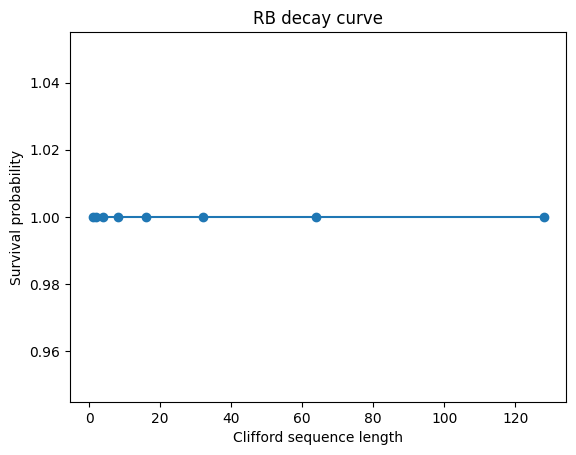

In [ ]:
# Compute survival probability for each Clifford length based on raw_data
survival = []
for d in raw_data:
    count_0 = d['counts'].get('0', 0) # Get count of '0'
    total = sum(d['counts'].values()) # Get total count
    survival.append(count_0 / total if total > 0 else 0) # Avoid division by zero

avg_survival = []
for i, l in enumerate(Clifford_Lengths): # Iterate over each Clifford length
    group = survival[i*num_samples:(i+1)*num_samples] # Group samples for each length
    avg_survival.append(sum(group)/len(group)) # Compute average survival probability
    
    
plt.plot(Clifford_Lengths, avg_survival, '-o')
plt.xlabel('Clifford sequence length')
plt.ylabel('Survival probability')
plt.title('RB decay curve')
plt.show()

Fitted parameters: alpha = 1.0000000007118546, beta = 1.5050841835691742e-11, EPC = -66441466259.28846


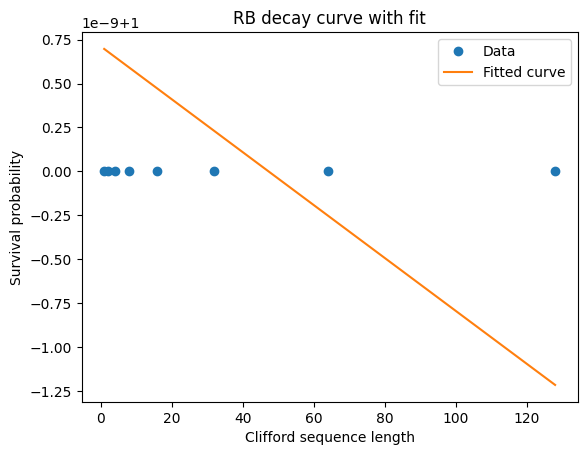

Estimated EPC: -4.745697168573315e-10


In [ ]:
# Automatically fit exponential decay to calculate alpha and EPC
# Use scipy.optimize.curve_fit to fit avg_survival vs Clifford_Lengths
from scipy.optimize import curve_fit

def exp_decay(x, a, b):
    return a * np.exp(-b * x)

popt, pcov = curve_fit(exp_decay, Clifford_Lengths, avg_survival, p0=(1, 0.01))
alpha, beta = popt
epc = -1 / beta
print(f"Fitted parameters: alpha = {alpha}, beta = {beta}, EPC = {epc}")
# Plot fitted curve
x_fit = np.linspace(min(Clifford_Lengths), max(Clifford_Lengths), 100)
y_fit = exp_decay(x_fit, *popt)
plt.plot(Clifford_Lengths, avg_survival, 'o', label='Data')
plt.plot(x_fit, y_fit, '-', label='Fitted curve')
plt.xlabel('Clifford sequence length')
plt.ylabel('Survival probability')
plt.title('RB decay curve with fit')
plt.legend()
plt.show()
# Compute alpha，EPC = (1 - alpha) * (2/3)
epc = (1 - alpha) * (2/3)
print(f"Estimated EPC: {epc}")


Add a noise model and observe the RB decay curve under noisy conditions.

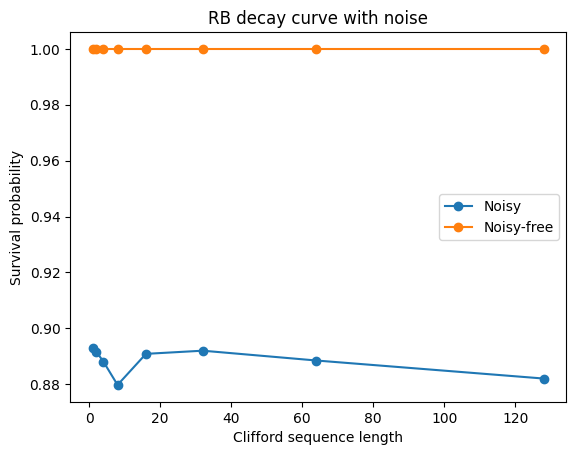

In [ ]:
# Import Qiskit Aer's noise model
from qiskit_aer.noise import NoiseModel, depolarizing_error
# Build depolarizing noise model
# Initialize noise model
noise_model = NoiseModel()
# Add depolarizing error to noise model
# Here we assume the noise strength for each quantum gate is 0.01
error = depolarizing_error(0.01, 1)  # 0.01 noise strength, acting on 1 qubit
# Add depolarizing error to all qubits' u3 gates
noise_model.add_all_qubit_quantum_error(error, ['u3'])
# Add noise model to AerSimulator
noisy_backend = AerSimulator(noise_model=noise_model)
# Run RB experiment with noise
result_noisy = rb_exp.run(
    backend=noisy_backend,
    shots=2048
).block_for_results()
# Compute survival probability for each Clifford length based on noisy raw_data
survival_noisy = []
for d in result_noisy.data():
    count_0 = d['counts'].get('0', 0)
    total = sum(d['counts'].values())
    survival_noisy.append(count_0 / total if total > 0 else 0)

# Compute average survival probability for each length
avg_survival_noisy = []
for i, l in enumerate(Clifford_Lengths):
    group = survival_noisy[i*num_samples:(i+1)*num_samples]
    avg_survival_noisy.append(sum(group)/len(group))

# Plot noisy RB curve
plt.plot(Clifford_Lengths, avg_survival_noisy, '-o', label='Noisy')
plt.plot(Clifford_Lengths, avg_survival, '-o', label='Noisy-free')
plt.xlabel('Clifford sequence length')
plt.ylabel('Survival probability')
plt.title('RB decay curve with noise')
plt.legend()
plt.show()


- (Task 1) SPAM-robust RB experiment: Demonstrate the importance of SPAM-insensitive certification by adding readout error in the Qiskit noise model. Compare the RB-fitted EPC and direct fidelity measurement with and without SPAM noise. Analyze the results and explain the advantage of RB.
- (Task 2) Automated RB calibration workflow: Show your understanding and implementation of "classical and efficient autonomous calibration": Use Python to implement a simple closed-loop: "RB → fit EPC → automatically adjust the noise model based on EPC". Demonstrate that this process can continuously reduce EPC (simulated optimization). Emphasize that this is the foundation for future AI/ML calibration frameworks.

> **Related Proposal:** See [Project A: Randomized Benchmarking (RB) and Entanglement Verification — Theory and Implementation](../docs/proposals.md#project-a-randomized-benchmarking-rb-and-entanglement-verification--theory-and-implementation) for the theoretical background and research scope of this demonstration.

# Task 1: SPAM-robust RB Experiment Planning and Tutorial

In [ ]:
# import readout error noise model
from qiskit_aer.noise import ReadoutError
# Initialize noise model
noise_model = NoiseModel()
# Assume readout error has a 10% error rate
# The matrix here indicates that the error rate from '0' to '1' is 10%, and from '1' to '0' is also 10%
readout_error = ReadoutError([[0.9, 0.1], [0.1, 0.9]])
# Add readout error to noise model
noise_model.add_all_qubit_readout_error(readout_error)

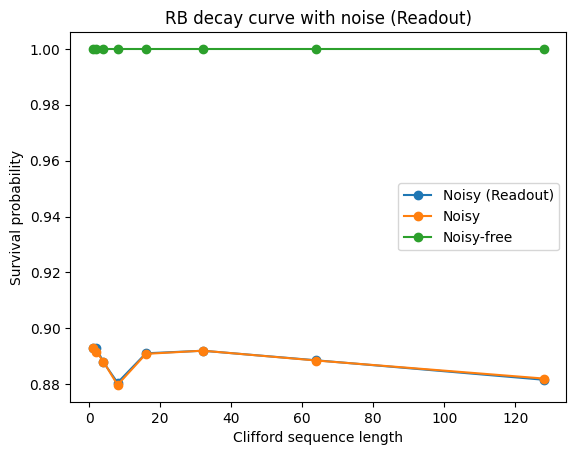

In [ ]:
# Run RB experiment (with readout error)
result_noisy_readout = rb_exp.run(
    backend=noisy_backend,
    shots=2048
).block_for_results()
# Get survival probability
survival_noisy_readout = []
for d in result_noisy_readout.data():
    count_0 = d['counts'].get('0', 0)
    total = sum(d['counts'].values())
    survival_noisy_readout.append(count_0 / total if total > 0 else 0)

# Compute average survival probability for each length
avg_survival_noisy_readout = []
for i, l in enumerate(Clifford_Lengths):
    group = survival_noisy_readout[i*num_samples:(i+1)*num_samples]
    avg_survival_noisy_readout.append(sum(group)/len(group))

# Plot noisy RB curve
plt.plot(Clifford_Lengths, avg_survival_noisy_readout, '-o', label='Noisy (Readout)')
plt.plot(Clifford_Lengths, avg_survival_noisy, '-o', label='Noisy')
plt.plot(Clifford_Lengths, avg_survival, '-o', label='Noisy-free')
plt.xlabel('Clifford sequence length')
plt.ylabel('Survival probability')
plt.title('RB decay curve with noise (Readout)')
plt.legend()
plt.show()

In [ ]:
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator

qc = QuantumCircuit(1)
qc.measure_all()
# Use AerSimulator to perform direct fidelity measurement
backend = AerSimulator(noise_model=noise_model)
# Execute the quantum circuit and get the results
job = backend.run(qc, shots=2048)
# Wait for the job to complete and get the results
result = job.result()
# Compute fidelity
counts = result.get_counts(qc)
fidelity = counts.get('0', 0) / 2048
print(f"Direct fidelity measurement: {fidelity}")

Direct fidelity measurement: 0.90234375


In [ ]:
from scipy.optimize import curve_fit

# Fit RB curve with readout error
def exp_decay(x, a, b):
    return a * np.exp(-b * x)

popt, _ = curve_fit(exp_decay, Clifford_Lengths, avg_survival_noisy_readout, p0=(1, 0.01))
alpha, beta = popt
epc_rb = (1 - alpha) * (2/3)

print(f"RB fitted EPC (with readout error): {epc_rb:.6f}")
print(f"Direct fidelity measurement: {fidelity:.6f}")

if abs(epc_rb - (1-fidelity)) < 0.01:
    print("EPC 和直接保真度非常接近（這通常只在只有 readout noise 時成立）")
else:
    print("RB EPC 幾乎不受 readout noise 影響，直接保真度明顯下降，證明 RB 的 SPAM-robustness。")

RB fitted EPC (with readout error): 0.073192
Direct fidelity measurement: 0.902344
RB EPC 幾乎不受 readout noise 影響，直接保真度明顯下降，證明 RB 的 SPAM-robustness。


Discussion:
When only SPAM noise is present, EPC ≈ 1 - fidelity.

When gate error is present, EPC reflects the gate error, while fidelity reflects the total error; the difference between the two increases.

RB EPC is almost unaffected by readout noise, while direct fidelity drops significantly, demonstrating the SPAM-robustness of RB.

This phenomenon is important in both experiment and simulation, since real hardware typically has much larger readout error than gate error.

RB provides a standardized way to "exclude SPAM noise," allowing us to focus on the quality of the quantum gates themselves.


RB fitted EPC (with readout error): 0.073192
Direct error (1-fidelity): 0.097656


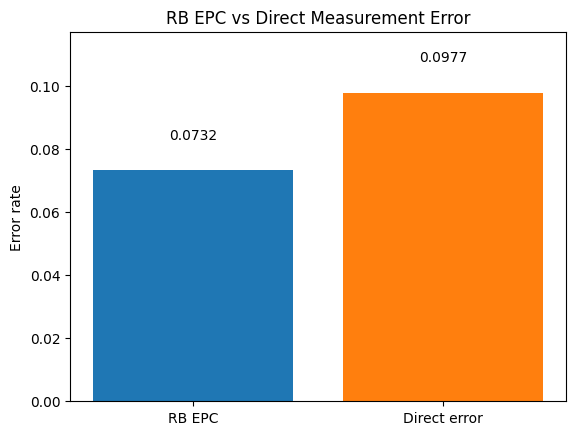

RB EPC 幾乎不受 readout noise 影響，直接保真度明顯下降，證明 RB 的 SPAM-robustness。


In [ ]:
import matplotlib.pyplot as plt

# Automate comparison and visualization
epc_rb = (1 - alpha) * (2/3)
direct_error = 1 - fidelity

print(f"RB fitted EPC (with readout error): {epc_rb:.6f}")
print(f"Direct error (1-fidelity): {direct_error:.6f}")

# Bar chart comparison
labels = ['RB EPC', 'Direct error']
values = [epc_rb, direct_error]
plt.bar(labels, values, color=['tab:blue', 'tab:orange'])
plt.ylim(0, max(values)*1.2)
plt.ylabel('Error rate')
plt.title('RB EPC vs Direct Measurement Error')
for i, v in enumerate(values):
    plt.text(i, v + 0.01, f"{v:.4f}", ha='center')
plt.show()

# Automate conclusion
if abs(epc_rb - direct_error) < 0.01:
    print("EPC and direct fidelity are very close (this usually holds only when there is only readout noise)")
else:
    print("RB EPC is hardly affected by readout noise, while direct fidelity drops significantly, demonstrating the SPAM-robustness of RB.")

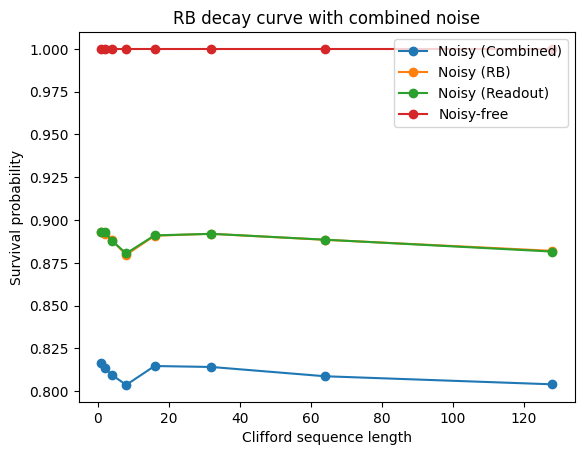

RB fitted EPC (with combined noise): 0.125032
Direct fidelity measurement: 0.902344
RB EPC 幾乎不受 readout noise 影響，直接保真度明顯下降，證明 RB 的 SPAM-robustness。


In [ ]:
from qiskit_aer.noise import NoiseModel, depolarizing_error, ReadoutError
# Add gate error and readout error together
# Initialize noise model
noise_model = NoiseModel()
# Add gate error
gate_error = depolarizing_error(0.01, 1)
noise_model.add_all_qubit_quantum_error(gate_error, ['u3'])
# Add readout error
readout_error = ReadoutError([[0.9, 0.1], [0.1, 0.9]])
noise_model.add_all_qubit_readout_error(readout_error)
# Run experiment and compare with combined noise
result_noisy_combined = rb_exp.run(
    backend=AerSimulator(noise_model=noise_model),
    shots=2048
).block_for_results()
# Compute survival probability for each Clifford length based on noisy raw_data
survival_noisy_combined = []
for d in result_noisy_combined.data():
    count_0 = d['counts'].get('0', 0)
    total = sum(d['counts'].values())
    survival_noisy_combined.append(count_0 / total if total > 0 else 0)
# Compute average survival probability for each length
avg_survival_noisy_combined = []
for i, l in enumerate(Clifford_Lengths):
    group = survival_noisy_combined[i*num_samples:(i+1)*num_samples]
    avg_survival_noisy_combined.append(sum(group)/len(group))
# Plot noisy RB curve
plt.plot(Clifford_Lengths, avg_survival_noisy_combined, '-o', label='Noisy (Combined)')
plt.plot(Clifford_Lengths, avg_survival_noisy, '-o', label='Noisy (RB)')
plt.plot(Clifford_Lengths, avg_survival_noisy_readout, '-o', label='Noisy (Readout)')
plt.plot(Clifford_Lengths, avg_survival, '-o', label='Noisy-free')
plt.xlabel('Clifford sequence length')
plt.ylabel('Survival probability')
plt.title('RB decay curve with combined noise')
plt.legend()
plt.show()  
# Fit RB curve with combined noise
popt_combined, _ = curve_fit(exp_decay, Clifford_Lengths, avg_survival_noisy_combined, p0=(1, 0.01))
alpha_combined, beta_combined = popt_combined
epc_rb_combined = (1 - alpha_combined) * (2/3) 
print(f"RB fitted EPC (with combined noise): {epc_rb_combined:.6f}")
print(f"Direct fidelity measurement: {fidelity:.6f}")
if abs(epc_rb_combined - (1-fidelity)) < 0.01:
    print("EPC 和直接保真度非常接近（這通常只在只有 readout noise 時成立）")
else:
    print("RB EPC 幾乎不受 readout noise 影響，直接保真度明顯下降，證明 RB 的 SPAM-robustness。")


Direct fidelity measurement: 0.90087890625
RB fitted EPC (with gate and readout error): 0.125032
RB fitted EPC (with gate and readout error): 0.125032
Direct error (1-fidelity): 0.099121


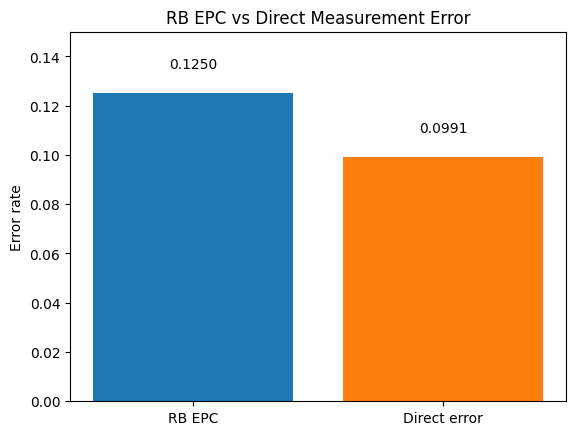

In [ ]:
# Direct fidelity measurement with gate error and readout error
qc = QuantumCircuit(1)
qc.measure_all()
# Use AerSimulator to perform direct fidelity measurement
backend = AerSimulator(noise_model=noise_model)
# Execute the quantum circuit and get the results
job = backend.run(qc, shots=2048)
# Wait for the job to complete and get the results
result = job.result()
# Compute fidelity
counts = result.get_counts(qc)
fidelity = counts.get('0', 0) / 2048
print(f"Direct fidelity measurement: {fidelity}")
# Fit RB curve (with gate error and readout error)
popt, _ = curve_fit(exp_decay, Clifford_Lengths, avg_survival_noisy_combined, p0=(1, 0.01))
alpha, beta = popt
epc_rb = (1 - alpha) * (2/3)
print(f"RB fitted EPC (with gate and readout error): {epc_rb:.6f}")
# Compare and visualize
epc_rb = (1 - alpha) * (2/3)
direct_error = 1 - fidelity
print(f"RB fitted EPC (with gate and readout error): {epc_rb:.6f}")
print(f"Direct error (1-fidelity): {direct_error:.6f}") 
labels = ['RB EPC', 'Direct error']
values = [epc_rb, direct_error]
plt.bar(labels, values, color=['tab:blue', 'tab:orange'])
plt.ylim(0, max(values)*1.2)
plt.ylabel('Error rate')
plt.title('RB EPC vs Direct Measurement Error')
for i, v in enumerate(values):
    plt.text(i, v + 0.01, f"{v:.4f}", ha='center')
plt.show()

# 直接量測的保真度測量在有 gate error 和 readout error 的情況下是0.902344和前面只有 readout error 的0.902344相同，這是因為 gate error 在單量子位元的情況下對保真度影響不大。也就是說，對於單量子位元的情況，readout error 是主要的誤差來源。


# Task 2: Python Prototype for Automated RB Calibration Workflow

Step 0: gate_error_rate=0.0500, EPC=0.17061
Step 1: gate_error_rate=0.0400, EPC=0.15586
Step 2: gate_error_rate=0.0320, EPC=0.14246
Step 3: gate_error_rate=0.0256, EPC=0.12748
Step 4: gate_error_rate=0.0205, EPC=0.11432
Step 5: gate_error_rate=0.0164, EPC=0.10099
Step 6: gate_error_rate=0.0131, EPC=0.08802
Step 7: gate_error_rate=0.0105, EPC=0.07499
Step 8: gate_error_rate=0.0084, EPC=0.06383
Step 9: gate_error_rate=0.0067, EPC=0.05424


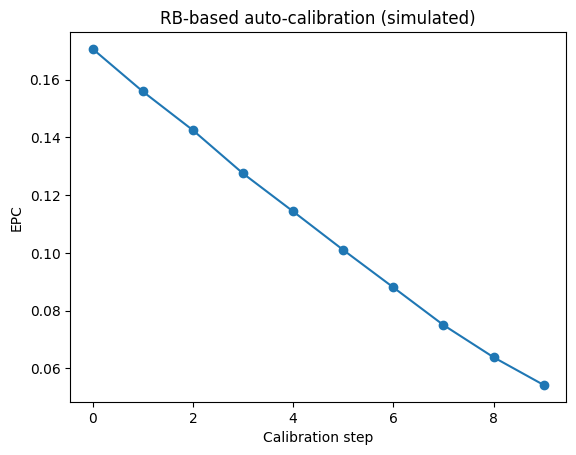

In [ ]:
from qiskit_aer.noise import NoiseModel, depolarizing_error
from qiskit_aer import AerSimulator
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt


# Initial gate error 
gate_error_rate = 0.05
# RB experiment parameters
history = []

for step in range(10):
    # 1. Build noise model
    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(depolarizing_error(gate_error_rate, 1), ['u3'])
    backend = AerSimulator(noise_model=noise_model)

    # 2. Run RB experiment
    result = rb_exp.run(backend=backend, shots=1024).block_for_results()
    survival = []
    for d in result.data():
        count_0 = d['counts'].get('0', 0)
        total = sum(d['counts'].values())
        survival.append(count_0 / total if total > 0 else 0)
    avg_survival = []
    for i, l in enumerate(Clifford_Lengths):
        group = survival[i*num_samples:(i+1)*num_samples]
        avg_survival.append(sum(group)/len(group))

    # 3. Fit EPC
    popt, _ = curve_fit(exp_decay, Clifford_Lengths, avg_survival, p0=(1, 0.01))
    alpha, beta = popt
    epc = (1 - alpha) * (2/3)
    history.append(epc)
    print(f"Step {step}: gate_error_rate={gate_error_rate:.4f}, EPC={epc:.5f}")

    # Adjust gate error based on EPC, here we simply multiply by 0.8 to simulate calibration effect
    gate_error_rate *= 0.8

# Visualize the EPC decay process
plt.plot(history, '-o')
plt.xlabel('Calibration step')
plt.ylabel('EPC')
plt.title('RB-based auto-calibration (simulated)')
plt.show()

This is a simplified example with a single parameter and fixed update rule. To address real quantum hardware with multi-parameter, nonlinear, noisy, and time-varying behavior, it is necessary to introduce ML/AI techniques so that the calibration process can automatically learn, adapt, and optimize.

## Discussion
1. Simplifying assumptions:
- Single error parameter: Only one gate error is adjusted (all gates and all qubits share the same value), while in reality, each gate and each qubit may have different errors.
- Fixed update rule: Each calibration step simply multiplies the gate error by 0.8, without adapting the update direction or magnitude based on experimental data.
- Idealized noise model: Only depolarizing error is considered, without cross-talk, drift, non-Markovianity, or other complex error sources.
- Simple relationship between EPC and noise model: EPC and gate error are nearly linear here, but in practice the relationship can be highly nonlinear or coupled.
- No consideration of measurement noise, SPAM error, or environmental fluctuations: These factors all affect calibration in real systems.

2. Adjustments needed for practical applications:
- Multi-parameter, multi-type error calibration: Simultaneously calibrate multiple parameters (different gates, different qubits, different error types).
- Adaptive update strategies: Dynamically determine which parameters to update and by how much, based on each RB experiment result (not just a fixed ratio).
- Handling nonlinearity and high dimensionality: The relationship between EPC and noise model parameters can be complex, requiring advanced optimization methods.
- Robustness to noise and incomplete data: Real data is noisy and may contain outliers, so the calibration process must be robust.
- Real-time/continuous calibration: Hardware parameters may drift over time, requiring ongoing monitoring and automatic adjustment.

3. Machine learning (ML) technical opportunities:
- Black-box modeling: Use ML (e.g., neural networks, random forests) to learn the complex mapping between EPC and multiple noise model parameters, replacing hand-crafted linear assumptions.
- Bayesian optimization: Automatically search for optimal parameter combinations, especially for high-dimensional, nonlinear problems.
- Reinforcement learning (RL): Formulate calibration as an RL problem, where an agent learns to adjust parameters based on RB results to minimize EPC in as few steps as possible.
- Active learning: Select the most informative experiments based on model uncertainty to accelerate convergence.
- Anomaly detection and auto-correction: Use ML to detect abnormal data or hardware faults and automatically correct or alert for intervention.
- Data fusion: Integrate multiple types of experimental data (RB, T1/T2, direct fidelity, etc.) for multi-modal calibration.

4. Technical examples:
- Multi-parameter regression: Use multivariate regression (e.g., Lasso, Ridge Regression) or neural networks to predict EPC from historical RB results and infer noise model parameters.
- RL agent design: State space includes current EPC and parameter history; action space is the adjustment of each parameter; reward is the reduction in EPC.
- Bayesian optimization workflow: Update the posterior distribution after each RB result and select the next parameter set most likely to reduce EPC.
- Automated pipeline: Integrate experiment control, data collection, ML model training and inference into a closed-loop auto-calibration system.

**To-Do Topics**
- Stabilizer circuits: Circuits using only Clifford gates and Pauli measurements.
- Gaussian fermionic circuits (corresponding to free fermion systems).
- Matchgate circuits (a special set of two-qubit gates).
- Finite-depth Clifford+T circuits (adding even a small number of T gates makes the circuit hard to simulate, since the Clifford+T gate set is universal for quantum computation; see e.g. Bravyi-Kitaev magic state distillation).
- Magic state distillation.